In [100]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.feature as cfeature

import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw

import warnings
warnings.filterwarnings('ignore')

## Export the Statistics and Extreme Quantiles for rain gauges

In [36]:
yy_s, yy_e = 2002, 2023
years_num = yy_e - yy_s + 1

In [16]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

In [3]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges')

In [21]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load METADATA

In [5]:
METADATA = pd.read_csv(os.path.join(dir_base, 'METADATA', 'METADATA_INTENSE_NOQC_update.csv'))
METADATA.head(2)

,File,ISO,Region,Code,Name,Elevation,Orig_EPSG,CRS_E,CRS_N,Lat,Lon,Year_Start,Year_End,INTENSE_Resp,AGENCY,Source,TimeZone,Agency
0,IT-210_PIE-001030-900_0060.csv,IT-210,Piedmont,PIE-001030-900,BORGOFRANCODIVREA,337.0,32632.0,410005.0,5040731.0,45.514302,7.847798,1988-05-08 05:00:00,2024-09-09 01:00:00,DT,ARPA Piemonte,Piedmont,UTC,NaN
1,IT-210_PIE-001097-900_0060.csv,IT-210,Piedmont,PIE-001097-900,CUMIANA,327.0,32632.0,373092.0,4980177.0,44.963696,7.390821,1988-01-29 03:00:00,2024-09-18 12:00:00,DT,ARPA Piemonte,Piedmont,UTC,NaN


## List raingauges directories

In [6]:
dir_read = os.path.join(dir_base, 'DATA_1dy', 'raingauges')
dirs = [d for d in os.listdir(dir_read) if os.path.isdir(os.path.join(dir_read, d))]

## Choose one Region

Text(0.0, 1.0, 'Total of Rain Gauges: 3180')

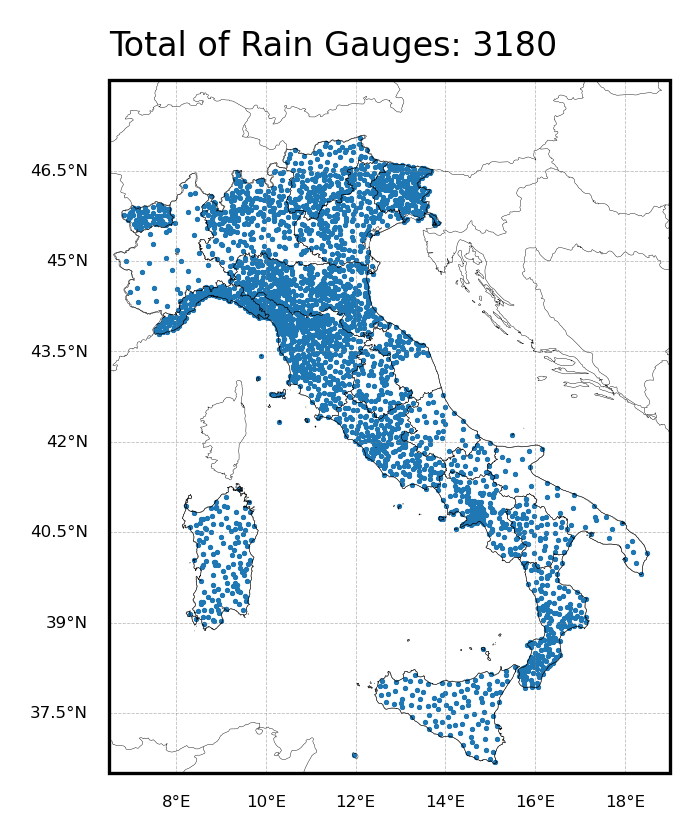

In [187]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# =============================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.1,color='black',zorder=4)
REGIONS.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.1)

ax1.scatter(METADATA['Lon'], METADATA['Lat'], s=0.1, marker='*')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'Total of Rain Gauges: {len(METADATA)}', fontsize=8, loc='left')

## Verify Region statistic directories

In [156]:
regions_ISO = sorted(METADATA['ISO'].unique())

In [ ]:
for nn in range(len(regions_ISO)):
    region_dir = os.path.join(dir_base, 'DATA_1dy', 'statistics', regions_ISO[nn])
    if not os.path.exists(region_dir):
        os.makedirs(region_dir)
        print(f"Created: {region_dir}")
    else:
        print(f"Already exists: {region_dir}")

Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-210
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-230
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-250
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-321
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-322
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-340
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-360
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-420
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-450
Already exists: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/DATA_1dy/statistics/IT-520
Already exists: /media/arturo/

## Create statistics for each region

In [184]:
for rr in range(len(regions_ISO)):
    region_ = regions_ISO[rr] 
    print(f'Region: {region_}')

    METADATA_clear = METADATA[METADATA['ISO']==region_].reset_index(inplace=False)

    names, lats, lons, Q5, Q10, Q20, Q50, Q100 = [], [], [], [], [], [], [], []
    for nn in range(len(METADATA_clear)):#len(METADATA_clear)

        filename = f'{METADATA_clear['File'].values[nn]}'
        RAIN_pd = pd.read_csv(os.path.join(dir_base, 'DATA_1dy', 'raingauges', region_, filename))
        RAIN_pd['Datetime'] = pd.to_datetime(RAIN_pd['Datetime'].values)
        
        ss, ee = RAIN_pd['Datetime'][0].year, RAIN_pd['Datetime'][len(RAIN_pd['Datetime'])-1].year

        RAIN_xr = xr.DataArray(
                        RAIN_pd['pre'].values,
                        coords={'time':RAIN_pd['Datetime'].values}, 
                        dims=('time'))

        NCWy, YEARSy = DOWN_raw.fit_yearly_weibull(RAIN_xr,1)
        N = NCWy[:,0]
        C = NCWy[:,1]
        W = NCWy[:,2]
        Y = YEARSy

        mask = (N == 0)
        N[mask] = np.nan
        C[mask] = np.nan
        W[mask] = np.nan

        STATISTIC = pd.DataFrame({'Year':Y.astype(int), 'N': N, 'C': C, 'W':W})

        dir_out = os.path.join(dir_base, 'DATA_1dy', 'statistics', region_, filename)
        STATISTIC.to_csv(dir_out, header=True, index=False)

Region: IT-210
Region: IT-230
Region: IT-250
Region: IT-321
Region: IT-322
Region: IT-340
Region: IT-360
Region: IT-420
Region: IT-450
Region: IT-520
Region: IT-550
Region: IT-570
Region: IT-620
Region: IT-650
Region: IT-670
Region: IT-720
Region: IT-750
Region: IT-770
Region: IT-780
Region: IT-820
Region: IT-880


In [ ]:


    # Compute the Extreme quantiles
    # Tr = [5, 10, 20, 50, 100]
    # Fi = 1 - 1/np.array(Tr)     
    # x0 = np.nanmean(C)
    # TMP_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, N, C, W, thresh=1)
    # TMP_Q2 = np.where(flag, TMP_Q, np.nan)

    # Q5.append(float(np.round(TMP_Q2[0],4)))
    # Q10.append(float(np.round(TMP_Q2[1],4)))
    # Q20.append(float(np.round(TMP_Q2[2],4)))
    # Q50.append(float(np.round(TMP_Q2[3],4)))
    # Q100.append(float(np.round(TMP_Q2[4],4)))

# Quantiles_OBS['Q5'] = Q5
# Quantiles_OBS['Q10'] = Q10
# Quantiles_OBS['Q20'] = Q20
# Quantiles_OBS['Q50'] = Q50
# Quantiles_OBS['Q100'] = Q100

In [177]:
N

array([101.,  78., 115., 107., 131.,  84.,  95., 130., 126.,  81., 104.,
        81.,  47.,  52., 104.,  32.,  64.,  91.,  90.])

In [143]:
YEARSy

array([2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.,
       2024.])